# Data Science Milestone
## Kasper Erik Schmidt-Christensen (hqr618) og Thor Steen Larsen (mvj665)
## Group 40

Follwing is our answers to the tasks given in the first milestone of our data science project. \\
Don't hit the "run" button. You are not able to run any of the code yourself.

# Task 2

Our schema design for the Fake News Dataset is as in the following ER-Diagram.

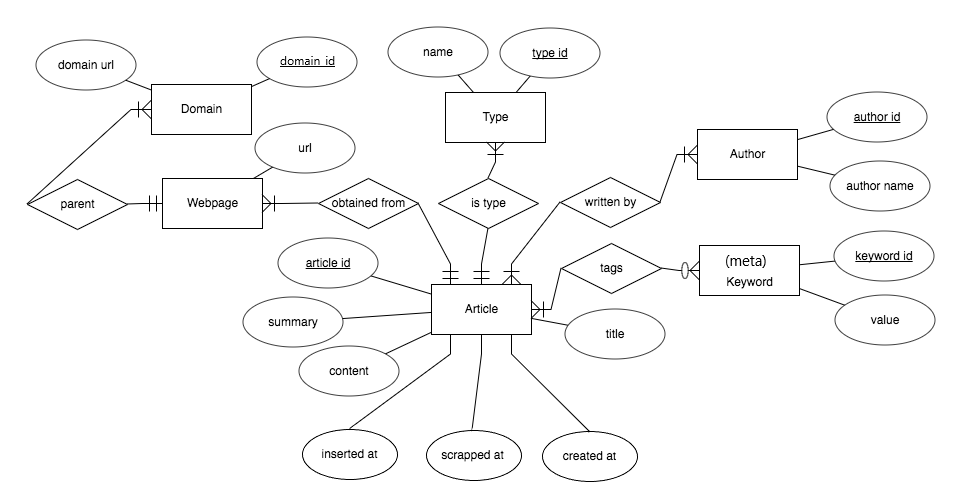

We use article_id as the primary key in the article table. This primary key is used a foreign key in the tags, author relation, type and obtained from / webpage relation. These foreign keys contraints the id is the related tables and make us able to relate article_id to keyword_id, domain_id etc..

By using this schema, we can easily couple articles with different keywords, authors, domain and types.

We use a python script using pandas and csv packages to clean and write the neccesary files. Futheremore, we use a sql script which create and populate our data base.

We find many holes such as empty rows and several invalid columns such as 'sources' in the dataset. Furthermore, authors and meta_keywords need to split into seperate strings. This means that we have to pre-process a good deal to be able to write the neccesary files.

To clean the content section, we also have to use regex which and use different patterns. Date has the most abigous pattern, and we need a broad regex pattern to find dates such as Februrary the 4th 2013 and Feb 4th '13 and 04-02-2013 etc.. This has a high computational cost and cleaning the content feild is diffenitely the process of the script with the longest running time. 
The python script is run on the "1mio-raw" dataset and a laptop with 6 cores and 8 gb of RAM and SSD which means we have to clean the content in chunks. Futhermore, we split the 1mio-raw dataset to a 500k dataset and delelete empty rows to be able to iterate faster in our work. Total running time is around 14 min.

To ensure that tags_relation, written_by_relation and other relations in the database are correct, we create 4 dictionaries where we put all entries and give them all unique ids.

As article_id we use the columns 'id' which are unique int values already made by the currators of the dataset.

Pandas have some good functions for making csvs, but to use the dictionaries from before, we have to write directly to a csv file using std. IO function in Python.

Following is demonstration of the dataset final generated text files using Pandas and SQL. 

In [13]:
import pandas as pd
import numpy as np
#the original data set in a chunk
datatypes = {'id': np.int32, 
             'domain': str, 
             'type' : str, 
             'url' :str, 
             'content': str, 
             'scraped_at':str, 
             'inserted_at':str,
             'updated_at':str, 
             'title':str, 
             'authors':str, 
             'keywords':str, 
             'meta_keywords':str,
             'meta_description':str, 
             'tags':str
             }
cols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] #to skp index, source and meta_description column
df_chunk = pd.read_csv('../../Data/500k.csv', dtype=datatypes, encoding='utf-8', skip_blank_lines=True, 
                   chunksize = 10000, verbose = False, na_filter=True, usecols = cols)
for data in df_chunk:
    print(data.head)
    break

<bound method NDFrame.head of          id               domain        type  \
0         2        express.co.uk       rumor   
1         6   barenakedislam.com        hate   
2         7   barenakedislam.com        hate   
3         8   barenakedislam.com        hate   
4         9   barenakedislam.com        hate   
...     ...                  ...         ...   
9995  11272    beforeitsnews.com        fake   
9996  11273    beforeitsnews.com        fake   
9997  11274  canadafreepress.com  conspiracy   
9998  11275  canadafreepress.com  conspiracy   
9999  11276  canadafreepress.com  conspiracy   

                                                    url  \
0     https://www.express.co.uk/news/science/738402/...   
1     http://barenakedislam.com/category/donald-trum...   
2     http://barenakedislam.com/category/donald-trum...   
3     http://barenakedislam.com/2017/12/24/more-winn...   
4     http://barenakedislam.com/2017/12/25/oh-trump-...   
...                                    

After running the actual python script (not shown here) to create neccessary csv files, we use the following sql script to built and populate the database. 

CreateAndPopulate.sql
```
DROP TABLE Written_by CASCADE;
DROP TABLE Tags CASCADE;
DROP TABLE Webpage CASCADE;
DROP TABLE Article CASCADE;
DROP TABLE Typ CASCADE;
DROP TABLE Domain CASCADE;
DROP TABLE Author CASCADE;
DROP TABLE Keyword CASCADE;

CREATE TABLE Keyword (
  keyword_id serial,
  keyword varchar(128),
  PRIMARY KEY (keyword_id)
);

CREATE TABLE Author (
  author_id serial,
  author_name varchar(64),
  PRIMARY KEY (author_id)
);

CREATE TABLE Domain (
  domain_id serial,
  domain_url varchar(1024),
  PRIMARY KEY (domain_id)
);

CREATE TABLE Typ (
  type_id serial,
  type_name varchar(64),
  PRIMARY KEY (type_id)
);

CREATE TABLE Article (
  article_id integer,
  title varchar (512),
  content text,
  summary text,
  meta_description text,
  type_id integer REFERENCES Typ(type_id),
  inserted_at timestamp,
  updated_at timestamp,
  scraped_at timestamp,
  PRIMARY KEY (article_id)
);

CREATE TABLE Webpage (
  url varchar(1024),
  article_id integer REFERENCES Article(article_id),
  domain_id integer REFERENCES Domain(domain_id)
);

CREATE TABLE Tags (
  article_id integer REFERENCES Article(article_id),
  keyword_id integer REFERENCES Keyword(keyword_id)
);

CREATE TABLE Written_by (
  article_id integer REFERENCES Article(article_id),
  author_id integer REFERENCES Author(author_id)
);

SET CLIENT_ENCODING TO 'utf8';

\copy keyword       from 'keyword_entity.csv'       delimiter','csv;
\copy author        from 'author_entity.csv'        delimiter','csv;
\copy typ           from 'type_entity.csv'          delimiter','csv;
\copy domain        from 'domain_entity.csv'        delimiter','csv;
\copy article       from 'article_entity.csv'       delimiter'^'csv;
\copy tags          from 'tags_relation.csv'        delimiter','csv;
\copy written_by    from 'writtenBy_relation.csv'   delimiter','csv;
\copy webpage       from 'webpage_relation.csv'     delimiter','csv;
```



In [17]:
import psycopg2

conn = psycopg2.connect(database='fknew', user='tsl19', password='0312', host='localhost', port="5432")

SQL_test1 = pd.read_sql_query(
'''
SELECT COUNT(*) as count
FROM article
''', 
conn)

distinct_url = pd.DataFrame(SQL_test1, columns=['count'])

print('test1')
print(distinct_url.head)

SQL_test2 = pd.read_sql_query(
'''
SELECT COUNT(*) as count
FROM webpage
''', 
conn)

distinct_url = pd.DataFrame(SQL_test2, columns=['domain_url'])

print('test2')
print(distinct_url.head)

SQL_test3 = pd.read_sql_query(
'''
SELECT COUNT(*) as count
FROM tags
''', 
conn)

distinct_url = pd.DataFrame(SQL_test3, columns=['count'])

print('test3')
print(distinct_url.head)

SQL_test4 = pd.read_sql_query(
'''
SELECT COUNT(*) as count
FROM written_by
''', 
conn)

distinct_url = pd.DataFrame(SQL_test4, columns=['count'])

print('test4')
print(distinct_url.head)

SQL_test5 = pd.read_sql_query(
'''
SELECT *
FROM written_by
''', 
conn)

distinct_url = pd.DataFrame(SQL_test5, columns=['article_id' , 'author_id'])

print('test5')
print(distinct_url.head)

SQL_test6 = pd.read_sql_query(
'''
SELECT *
FROM tags
''', 
conn)

distinct_url = pd.DataFrame(SQL_test6, columns=['article_id' , 'keyword_id'])

print('test6')
print(distinct_url.head)

SQL_test7 = pd.read_sql_query(
'''
SELECT *
FROM typ
''', 
conn)

distinct_url = pd.DataFrame(SQL_test7, columns=['type_id' , 'type_name'])

print('test7')
print(distinct_url.head)

test1
<bound method NDFrame.head of     count
0  499976>
test2
<bound method NDFrame.head of    domain_url
0         NaN>
test3
<bound method NDFrame.head of     count
0  816861>
test4
<bound method NDFrame.head of      count
0  1215249>
test5
<bound method NDFrame.head of          article_id  author_id
0                 2    33361.0
1                 6    22568.0
2                 6     7360.0
3                 6     3053.0
4                 6    22524.0
...             ...        ...
1215244      572072        0.0
1215245      572073        0.0
1215246      572074     4086.0
1215247      572074    21969.0
1215248      572074    31827.0

[1215249 rows x 2 columns]>
test6
<bound method NDFrame.head of         article_id  keyword_id
0               17       79022
1               17       51905
2               17       82735
3               17       31681
4               17       31680
...            ...         ...
816856      572059       16497
816857      572059       16498
816858    

# Task 3

We wrap the neccesary sql commands in psycopg2 and save the results to memory.

part 1 algebra

π domain_url σ type_name = 'reliable' Domain ⨝ Webpage ⨝ Article ⨝ Typ

part 2 algebra

If we first make myTable as a view instead of inclusing it as with section of the query, it can be expressed with the following relational algebra

π author_name σ nbr_of_arts = (π nbr_of_arts γ ; MAX(nbr_of_arts)myTable) myTable

In [18]:
SQL_Query1 = pd.read_sql_query(
'''
SELECT distinct domain_url 
FROM Domain NATURAL JOIN webpage NATURAL JOIN article NATURAL JOIN typ 
WHERE type_name = 'reliable'
''', 
conn)

distinct_url = pd.DataFrame(SQL_Query1, columns=['domain_url'])

print('Query1')
print(distinct_url.head)

SQL_Query2 = pd.read_sql_query(
''' 
SELECT       author_name,             COUNT(author) AS value_occurrence 
FROM     author NATURAL JOIN written_by NATURAL JOIN article NATURAL JOIN typ
WHERE    type_name = 'fake'
GROUP BY author_name
ORDER BY value_occurrence DESC
''',
conn)

print('Query2')
author_names = pd.DataFrame(SQL_Query2, columns=['author_name','value_occurrence'])
print(author_names.head)

#returns keywords and their count which seems correct
SQL_Query3 = pd.read_sql_query(
'''
WITH tags_s AS (SELECT * FROM tags WHERE article_id <= 1000), 
    arts_s AS (SELECT DISTINCT article_id FROM tags_s)

SELECT arts1.article_id as id1, arts2.article_id as id2

FROM arts_s arts1, arts_s arts2

WHERE arts1.article_id < arts2.article_id
AND 1 = ((SELECT COUNT(*)
                FROM (
    (
        SELECT tags_s.keyword_id
        FROM tags_s
        WHERE arts1.article_id = tags_s.article_id 
    ) INTERSECT (
        SELECT tags_s.keyword_id
        FROM tags_s
        WHERE arts2.article_id = tags_s.article_id 
        ) ) as foo
) / (SELECT COUNT(*)
    FROM(
    (
        SELECT tags_s.keyword_id
        FROM tags_s
        WHERE arts1.article_id = tags_s.article_id 
    ) UNION (
        SELECT tags_s.keyword_id
        FROM tags_s
        WHERE arts2.article_id = tags_s.article_id 
    )) as bar 
    ));

''',
conn)

equal_keyword_article_count = pd.DataFrame(SQL_Query3, columns=['id1','id2'])

print('Query3')
print(equal_keyword_article_count.head)

Query1
<bound method NDFrame.head of            domain_url
0   christianpost.com
1  consortiumnews.com
2  nutritionfacts.org>
Query2
<bound method NDFrame.head of                     author_name  value_occurrence
0                          None             24056
1     zacks investment research               930
2                    john rolls               928
3                freedom bunker               859
4               reason magazine               674
...                         ...               ...
2160         ap business writer                 1
2161   anyone who knows of cent                 1
2162                 the coyote                 1
2163      antonio maria delgado                 1
2164           anthony migchels                 1

[2165 rows x 2 columns]>
Query3
<bound method NDFrame.head of     id1  id2
0   522  682
1   522  816
2   522  678
3   522  644
4   522  568
5   682  816
6   678  682
7   678  816
8   644  682
9   644  816
10  644  678
11  167  522
12  1

# Task 4

Some interesting oberservations: Authors always write the same type(fake, reliable, political, etc.), this also goes for domains, this is partially because the authors stick to one domain in the data set. Keywords generally also point to a single type of source, with a few exceptions like 'Donald' and 'Trump' that can either be 'fake' or 'political'. 

The SQL queries we used to discover this can be seen below, first we create a materialized view for each, and then we get a list ordered by auther, domain or keyword. You could also make a query where you join the materialized view on its self on the author, domain, or keyword and then keep those where the types are different to see if they only belong to one type, but this way we also get to see which types are tied to what authors, domains, and keywords.

In [0]:
pd.read_sql_query('''DROP MATERIALIZED VIEW articles_per_domain_and_type;''', conn)
pd.read_sql_query('''DROP MATERIALIZED VIEW articles_per_author_and_type;''', conn)
pd.read_sql_query('''DROP MATERIALIZED VIEW articles_per_keyword_and_type;''', conn)

In [19]:

# Forth query, finds articles per domain and type, as the name suggests. 
SQL_Query4 = pd.read_sql_query(
'''
CREATE MATERIALIZED VIEW
articles_per_domain_and_type
    (domain, typ, article_count)
    AS (SELECT domain_url, type_name, COUNT(*) as count
        FROM article NATURAL JOIN typ NATURAL JOIN webpage NATURAL JOIN domain
        WHERE domain_url IS NOT NULL AND type_name != '<null>'
        GROUP BY domain_url, type_name);

select * from articles_per_domain_and_type order by domain;
''',
conn)


print('Query4')
articles_per_domain_and_type = pd.DataFrame(SQL_Query4, columns=['domain','typ','article_count'])
print(articles_per_domain_and_type.head)

# Fith query, finds articles per author and type, as the name suggests. 
SQL_Query5 = pd.read_sql_query(
'''
CREATE MATERIALIZED VIEW
articles_per_author_and_type
    (author, typ, article_count)
    AS (SELECT author_name, type_name, COUNT(*) as count
        FROM article NATURAL JOIN typ NATURAL JOIN written_by NATURAL JOIN author
        WHERE author_name != '<null>' AND type_name != '<null>'
        GROUP BY author_name, type_name);

select * from articles_per_author_and_type order by author;
''',
conn)



print('Query5')
articles_per_author_and_type = pd.DataFrame(SQL_Query5, columns=['author','typ','article_count'])
print(articles_per_author_and_type.head)

# Sixth query, finds articles per keyword and type, as the name suggests. 
SQL_Query6 = pd.read_sql_query(
'''
CREATE MATERIALIZED VIEW
articles_per_keyword_and_type
    (keyword, typ, article_count)
    AS (SELECT keyword, type_name, COUNT(*) as count
        FROM article NATURAL JOIN typ NATURAL JOIN tags NATURAL JOIN keyword
        WHERE keyword != '<null>' AND type_name != '<null>'
        GROUP BY keyword, type_name);

select * from articles_per_keyword_and_type order by keyword;

''',
conn)


print('Query6')
articles_per_keyword_and_type = pd.DataFrame(SQL_Query6, columns=['keyword','typ','article_count'])
print(articles_per_keyword_and_type.head)

Query4
<bound method NDFrame.head of                       domain         typ  article_count
0        100percentfedup.com        bias             16
1        21stcenturywire.com  conspiracy            451
2             82.221.129.208  conspiracy              3
3    aanirfan.blogspot.co.uk  unreliable              1
4         abovetopsecret.com  conspiracy          32622
..                       ...         ...            ...
324            worldtruth.tv  conspiracy             48
325     yellowhammernews.com   political              9
326         yournewswire.com   clickbait           2959
327            zerohedge.com  conspiracy           6804
328             zootfeed.com  conspiracy            166

[329 rows x 3 columns]>
Query5
<bound method NDFrame.head of                                             author         typ  article_count
0                                       'bare feet   political              1
1                                        'esquire'   political           

In [22]:
conn.close()

# Task 5

"ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[40%23:40%23+10] = 'STUVWZABCD' = [S-Z, A-D]

Following is the code we use to crawl wikipedia

The comments mostly explain what is happening, some important keypoints are

1.

links = response.xpath('/html/body/div[3]/div[3]/div[4]/div[2]/div[2]/div/div/div/ul/li/a/@href').extract()

Finds all the links on the starting page with letter 'x', so we can open all those links and read the contents.


2.

nextpageurl1 = response.xpath("//*[@id='mw-pages']/a[contains(.,'next page')]/@href").get()

this finds the url of the 'next page' button so we keep crawling throught the pages until we hit a letter that is not in out set.


3.

text = response.xpath("""//div[contains(@class, 'mw-parser-output')]/p/descendant-or-self::text()[not( parent::strong )]""").extract()

this finds the text in all paragraphs within the division with class = 'mw-parser-output', and it also finds the text in any hyperlinks within the text.


In [0]:
import scrapy
import re
# Import the CrawlerProcess: for running the spider
#from scrapy.crawler import CrawlerProcess
class testSpider(scrapy.Spider):
    name = "wikitest"
    def start_requests(self):
        start_urls = [
            "https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&from=S", #Starts at page with S runs til end of alphabet
            "https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&from=A", #Starts at page with A runs til E
        ]

        #yield all the article links from the start urls
        for url in start_urls:
            yield scrapy.Request( url = url, callback = self.parse )
        
    def parse(self, response):    
        links = response.xpath('/html/body/div[3]/div[3]/div[4]/div[2]/div[2]/div/div/div/ul/li/a/@href').extract() # Get links from side

        WantedArticles =  r"/wiki/[A-D,S-Z]"  #regex for our letter range
        
        for link in links:
            if link and (re.match(WantedArticles , link) != None): #check if link is valid and is a wanted article( start with a letter in our range)
                yield response.follow(url = link, callback = self.parse2)


        forbiddenNP =  r"https:\/\/en\.wikinews\.org\/w\/index\.php\?title=Category:Politics_and_conflicts&pagefrom=E" #Stops when we run out of pages starting with E
        
        nextpageurl1 = response.xpath("//*[@id='mw-pages']/a[contains(.,'next page')]/@href").get()   # Finds next page url
        nextpageurl = response.urljoin(nextpageurl1)                                                  # same
        
        if nextpageurl and (re.match(forbiddenNP , nextpageurl ) == None):  #checks if next page url is within our letter range
            yield scrapy.Request(nextpageurl, callback=self.parse) # Return a call to the function "parse"

    #Will run over all individual articles and extract appropriate data
    def parse2(self, response):
        #return individual article 
        # title
        title = response.xpath('/html/body/div[3]/h1/text()').get()
        #source(s)
        source = response.xpath('/html/body/div[3]/div[3]/div[4]/div/ul/li/span/descendant-or-self::text()').extract()
        #date
        date = response.xpath('/html/body/div[3]/div[3]/div[4]/div/p[1]/strong/text()').get()
        #text TODO: add dl as part of sibling to p
        text = response.xpath("""//div[contains(@class, 'mw-parser-output')]/p/descendant-or-self::text()[not( parent::strong )]""").extract()

        finaltext = ''.join(text)

        finalsource = ''.join(source)

        yield {
            'title': title,
            'source' : finalsource,
            'date' : date,
            'text' : finaltext,
        }



From this we pull out af dataframe and find the attributes of our new dataset.

In [21]:
webScrapeDF = pd.read_csv('../wikitest/wiki.csv', encoding = 'utf-8')

print('{} articles scraped from wikinews.'.format(len(webScrapeDF)))
print(webScrapeDF.head)

3808 articles scraped from wikinews.
<bound method NDFrame.head of                                                   title  \
0                      Sabotage strikes French railways   
1        San Jose mayor Gonzales indicted on six counts   
2     San Francisco's Green Party endorses Cindy She...   
3         Sandra Fluke insists she will not be silenced   
4     Sandra Fluke declares candidacy for California...   
...                                                 ...   
3803  Saddam Hussein formally charged with the killi...   
3804                 Saddam Hussein executed by hanging   
3805         Saddam Hussein admits to requesting trials   
3806              Saddam Hussein 'forced' back to trial   
3807    SADC calls for transparent Mozambique elections   

                                                 source  \
0      "French trains 'hit by sabotage'" — BBC News ...   
1                                                   NaN   
2                                              

We see that the correct data is returned and similar formatted to that of the fakenews corpus. Further cleaning of the article content can easely be done from here if we e.g. was to do natural language processing and create machine learning models.